In [1]:
import sys

sys.path.insert(0, '..')

## Setup the model area

In [2]:
from morpheus.project.types.discretization import SpatialDiscretization
from morpheus.project.types.discretization.spatial import Rotation, Grid, Crs
from morpheus.project.types.geometry import Polygon, LineString

polygon = Polygon(
  type='Polygon',
  coordinates=[[
    (13.92, 50.964),
    (13.92, 50.966),
    (13.925, 50.966),
    (13.925, 50.964),
    (13.92, 50.964)
  ]]
)

rotation = Rotation(0)

grid = Grid.cartesian_from_polygon(polygon=polygon, n_cols=100, n_rows=50, rotation=rotation)
spatial_discretization = SpatialDiscretization.from_geometry_with_grid(
  geometry=polygon,
  grid=grid,
  crs=Crs.from_str('EPSG:4326')
)

## Setup Time Discretization

In [3]:
from morpheus.project.types.discretization.time.TimeUnit import TimeUnit
from morpheus.project.types.discretization.time.Stressperiods import StartDateTime, StressPeriodCollection, \
  StressPeriod, NumberOfTimeSteps, TimeStepMultiplier, IsSteadyState
from morpheus.project.types.discretization.time import TimeDiscretization
from datetime import datetime

time_discretization = TimeDiscretization(
  start_date_time=StartDateTime.from_datetime(datetime(2020, 1, 1)),
  end_date_time=StartDateTime.from_datetime(datetime(2020, 12, 31)),
  stress_periods=StressPeriodCollection([
    StressPeriod(
      start_date_time=StartDateTime.from_datetime(datetime(2020, 1, 1)),
      number_of_time_steps=NumberOfTimeSteps(1),
      time_step_multiplier=TimeStepMultiplier(1),
      steady_state=IsSteadyState.yes()
    ),
  ]),
  time_unit=TimeUnit.days()
)

# Setup Model

In [4]:
from morpheus.project.types.Model import Model

model = Model.new()
model = model.with_updated_time_discretization(time_discretization)
model = model.with_updated_spatial_discretization(spatial_discretization=spatial_discretization)

In [5]:
import folium

m = folium.Map(tiles="cartodbpositron", crs="EPSG3857", zoom_start=12, location=[50.965, 13.922])
m.add_child(folium.GeoJson(polygon.as_geojson()))

m.fit_bounds(m.get_bounds())
m

# Setup constant head boundary with two observations

In [6]:
from morpheus.project.types.boundaries.ConstantHeadObservation import ObservationId, HeadValue, ConstantHeadRawDataItem
from morpheus.project.types.geometry import Point
from morpheus.project.types.boundaries.Boundary import BoundaryName, BoundaryCollection
from morpheus.project.types.layers import LayerId
from morpheus.project.types.boundaries.Boundary import ConstantHeadBoundary, ConstantHeadObservation

layers_list = [LayerId.new()]

constant_head_east = ConstantHeadBoundary.from_geometry(
  name=BoundaryName('constant_head_east'),
  geometry=LineString([
    (13.92499, 50.966),
    (13.92499, 50.964),
  ]),
  grid=grid,
  affected_layers=[model.layers[0].layer_id],
  observations=[
    ConstantHeadObservation(
      observation_id=ObservationId.new(),
      geometry=Point((13.92499, 50.966)),
      raw_data=[
        ConstantHeadRawDataItem(
          date_time=StartDateTime.from_datetime(datetime(2019, 1, 1)),
          head=HeadValue.from_float(100),
        ),
        ConstantHeadRawDataItem(
          date_time=StartDateTime.from_datetime(datetime(2021, 12, 31)),
          head=HeadValue.from_float(100),
        ),
      ]
    ),
    ConstantHeadObservation(
      observation_id=ObservationId.new(),
      geometry=Point((13.92499, 50.964)),
      raw_data=[
        ConstantHeadRawDataItem(
          date_time=StartDateTime.from_datetime(datetime(2019, 1, 1)),
          head=HeadValue.from_float(200),
        ),
        ConstantHeadRawDataItem(
          date_time=StartDateTime.from_datetime(datetime(2021, 12, 31)),
          head=HeadValue.from_float(200),
        ),
      ]
    ),
  ]
)

constant_head_west = ConstantHeadBoundary.from_geometry(
  name=BoundaryName('constant_head_west'),
  geometry=LineString([
    (13.92004, 50.96401),
    (13.92004, 50.96599),
  ]),
  grid=grid,
  affected_layers=[model.layers[0].layer_id],
  observations=[
    ConstantHeadObservation(
      observation_id=ObservationId.new(),
      geometry=Point((13.92004, 50.96599)),
      raw_data=[
        ConstantHeadRawDataItem(
          date_time=StartDateTime.from_datetime(datetime(2019, 1, 1)),
          head=HeadValue.from_float(300),
        ),
        ConstantHeadRawDataItem(
          date_time=StartDateTime.from_datetime(datetime(2021, 12, 31)),
          head=HeadValue.from_float(300),
        ),
      ]
    ),
    ConstantHeadObservation(
      observation_id=ObservationId.new(),
      geometry=Point((13.92004, 50.96401)),
      raw_data=[
        ConstantHeadRawDataItem(
          date_time=StartDateTime.from_datetime(datetime(2019, 1, 1)),
          head=HeadValue.from_float(400),
        ),
        ConstantHeadRawDataItem(
          date_time=StartDateTime.from_datetime(datetime(2021, 12, 31)),
          head=HeadValue.from_float(400),
        ),
      ]
    ),
  ]
)

boundary_collection = BoundaryCollection.new()
boundary_collection.add_boundary(constant_head_west)
boundary_collection.add_boundary(constant_head_east)

model = model.with_updated_boundaries(boundaries=boundary_collection)

m.add_child(folium.GeoJson(constant_head_east.as_geojson()))
m.add_child(folium.GeoJson(constant_head_east.affected_cells.to_geojson(grid).as_geojson()))
for observation in constant_head_east.observations:
  m.add_child(folium.GeoJson(observation.as_geojson()))

m.add_child(folium.GeoJson(constant_head_west.as_geojson()))
m.add_child(folium.GeoJson(constant_head_west.affected_cells.to_geojson(grid).as_geojson()))
for observation in constant_head_west.observations:
  m.add_child(folium.GeoJson(observation.as_geojson()))
m.fit_bounds(m.get_bounds())
m

In [7]:
constant_head_east.observations

[ConstantHeadObservation(observation_id=ObservationId(value='11a69ba1-cd48-46ce-ab9b-2b28d6d76e3f'), geometry=Point(coordinates=(13.92499, 50.966), type='Point'), raw_data=[ConstantHeadRawDataItem(date_time=StartDateTime(value=datetime.datetime(2019, 1, 1, 0, 0, tzinfo=datetime.timezone.utc)), head=HeadValue(value=100)), ConstantHeadRawDataItem(date_time=StartDateTime(value=datetime.datetime(2021, 12, 31, 0, 0, tzinfo=datetime.timezone.utc)), head=HeadValue(value=100))]),
 ConstantHeadObservation(observation_id=ObservationId(value='dff7f974-2314-4bc6-b294-f0795b1fa042'), geometry=Point(coordinates=(13.92499, 50.964), type='Point'), raw_data=[ConstantHeadRawDataItem(date_time=StartDateTime(value=datetime.datetime(2019, 1, 1, 0, 0, tzinfo=datetime.timezone.utc)), head=HeadValue(value=200)), ConstantHeadRawDataItem(date_time=StartDateTime(value=datetime.datetime(2021, 12, 31, 0, 0, tzinfo=datetime.timezone.utc)), head=HeadValue(value=200))])]

In [8]:
from morpheus.project.infrastructure.calculation.engines.modflow_2005.packages.ChdPackageMapper import \
  calculate_chd_boundary_stress_period_data

result = calculate_chd_boundary_stress_period_data(
  spatial_discretization=spatial_discretization,
  time_discretization=time_discretization,
  layers=model.layers,
  chd_boundary=constant_head_west,
)
result.to_dict()

{0: [[0, 0, 0, 300.5050289789967, 300.5050289789967],
  [0, 1, 0, 302.5251892522284, 302.5251892522284],
  [0, 2, 0, 304.54535126413674, 304.54535126413674],
  [0, 3, 0, 306.5655150157982, 306.5655150157982],
  [0, 4, 0, 308.5856805068539, 308.5856805068539],
  [0, 5, 0, 310.60584773730386, 310.60584773730386],
  [0, 6, 0, 312.62601670750695, 312.62601670750695],
  [0, 7, 0, 314.6461874167454, 314.6461874167454],
  [0, 8, 0, 316.66635986573704, 316.66635986573704],
  [0, 9, 0, 318.68653405412294, 318.68653405412294],
  [0, 10, 0, 320.70670998226194, 320.70670998226194],
  [0, 11, 0, 322.72688764979523, 322.72688764979523],
  [0, 12, 0, 324.7470670563639, 324.7470670563639],
  [0, 13, 0, 326.7672482030445, 326.7672482030445],
  [0, 14, 0, 328.7874310884017, 328.7874310884017],
  [0, 15, 0, 330.80761571422977, 330.80761571422977],
  [0, 16, 0, 332.8278020790932, 332.8278020790932],
  [0, 17, 0, 334.847990182992, 334.847990182992],
  [0, 18, 0, 336.8681800270029, 336.8681800270029],
  [0,

In [9]:
from morpheus.project.infrastructure.calculation.engines.modflow_2005.packages.ChdPackageMapper import \
  calculate_chd_boundary_stress_period_data

result = calculate_chd_boundary_stress_period_data(
  spatial_discretization=spatial_discretization,
  time_discretization=time_discretization,
  layers=model.layers,
  chd_boundary=constant_head_east,
)
result.to_dict()

{0: [[0, 0, 99, 100.99997868936319, 100.99997868936319],
  [0, 1, 99, 102.99993735985626, 102.99993735985626],
  [0, 2, 99, 104.99989775163911, 104.99989775163911],
  [0, 3, 99, 106.99985986577755, 106.99985986577755],
  [0, 4, 99, 108.99982370191631, 108.99982370191631],
  [0, 5, 99, 110.9997892600554, 110.9997892600554],
  [0, 6, 99, 112.99975654055007, 112.99975654055007],
  [0, 7, 99, 114.99972554268979, 114.99972554268979],
  [0, 8, 99, 116.9996962671851, 116.9996962671851],
  [0, 9, 99, 118.99966871368073, 118.99966871368073],
  [0, 10, 99, 120.99964288253196, 120.99964288253196],
  [0, 11, 99, 122.9996187733835, 122.9996187733835],
  [0, 12, 99, 124.9995963858801, 124.9995963858801],
  [0, 13, 99, 126.99957572108755, 126.99957572108755],
  [0, 14, 99, 128.9995567775848, 128.9995567775848],
  [0, 15, 99, 130.99953955714815, 130.99953955714815],
  [0, 16, 99, 132.99952405835657, 132.99952405835657],
  [0, 17, 99, 134.99951028121004, 134.99951028121004],
  [0, 18, 99, 136.999498226

## Calculate

In [10]:
from morpheus.project.types.calculation.CalculationProfile import CalculationProfile, CalculationEngineType
from morpheus.project.types.calculation.Calculation import Calculation

calculation_profile = CalculationProfile.new(engine_type=CalculationEngineType.MF2005)
calculation = Calculation.new(model=model, calculation_profile=calculation_profile)

In [11]:
calculation = Calculation.from_dict(calculation.to_dict())
calculation.calculation_id

CalculationId(value='2669c851-41d0-4ab0-a6cf-3781b4f334d0')

In [12]:
from morpheus.project.infrastructure.calculation.services.CalculationService import CalculationService

calculation_service = CalculationService.from_calculation(calculation)
calculation_service.calculate()

Model(model_id=ModelId(value='af127ad9-e2d5-4be3-8f3b-16f908c203d2'), spatial_discretization=SpatialDiscretization(geometry=Polygon(coordinates=[[(13.92, 50.964), (13.92, 50.966), (13.925, 50.966), (13.925, 50.964), (13.92, 50.964)]], type='Polygon'), grid=Grid(origin=Point(coordinates=(13.920000000000002, 50.965999999999994), type='Point'), col_widths=[5.565974539662712, 5.565974539662712, 5.565974539662712, 5.565974539662712, 5.565974539662712, 5.565974539662712, 5.565974539662712, 5.565974539662712, 5.5659745396627045, 5.565974539662719, 5.565974539662712, 5.565974539662712, 5.5659745396627045, 5.565974539662719, 5.5659745396627045, 5.565974539662719, 5.565974539662719, 5.56597453966269, 5.565974539662719, 5.565974539662719, 5.5659745396627045, 5.565974539662719, 5.565974539662719, 5.5659745396627045, 5.5659745396627045, 5.5659745396627045, 5.565974539662733, 5.5659745396627045, 5.5659745396627045, 5.5659745396627045, 5.5659745396627045, 5.565974539662733, 5.5659745396627045, 5.5659

In [13]:
calculation_service.get_result()

CalculationResult(type=<CalculationResultType.SUCCESS: 'success'>, message='Calculation finished successfully', files=['af127ad9-e2d5-4be3-8f3b-16f908c203d2.dis', 'af127ad9-e2d5-4be3-8f3b-16f908c203d2.chd', 'af127ad9-e2d5-4be3-8f3b-16f908c203d2.lpf', 'af127ad9-e2d5-4be3-8f3b-16f908c203d2.bas', 'af127ad9-e2d5-4be3-8f3b-16f908c203d2.nam', 'af127ad9-e2d5-4be3-8f3b-16f908c203d2.pcg', 'af127ad9-e2d5-4be3-8f3b-16f908c203d2.oc', 'af127ad9-e2d5-4be3-8f3b-16f908c203d2.list', 'af127ad9-e2d5-4be3-8f3b-16f908c203d2.hds'], head_results=AvailableResults(times=[365.0], kstpkper=[(0, 0)], number_of_layers=1, number_of_observations=0), drawdown_results=None, budget_results=AvailableResults(times=[365.0], kstpkper=[(0, 0)], number_of_layers=0, number_of_observations=0), concentration_results=None)

In [14]:
head = calculation_service.read_head(0, 0)

In [15]:
import simplejson as json

json = json.dumps(head, ignore_nan=True)
json

'[[300.5050048828125, 302.4070129394531, 303.60198974609375, 304.3420104980469, 304.7590026855469, 304.9280090332031, 304.89898681640625, 304.7040100097656, 304.3659973144531, 303.906005859375, 303.33599853515625, 302.6679992675781, 301.9119873046875, 301.07501220703125, 300.1650085449219, 299.18701171875, 298.14599609375, 297.0469970703125, 295.89300537109375, 294.68798828125, 293.4360046386719, 292.13800048828125, 290.79901123046875, 289.41900634765625, 288.00201416015625, 286.5480041503906, 285.0610046386719, 283.5409851074219, 281.989990234375, 280.4100036621094, 278.802001953125, 277.1659851074219, 275.5050048828125, 273.8190002441406, 272.1090087890625, 270.375, 268.6199951171875, 266.8420104980469, 265.04400634765625, 263.22601318359375, 261.3869934082031, 259.5299987792969, 257.65301513671875, 255.75799560546875, 253.843994140625, 251.91299438476562, 249.96400451660156, 247.9969940185547, 246.01300048828125, 244.01199340820312, 241.99400329589844, 239.95799255371094, 237.904998

In [16]:
calculation_service.read_drawdown(0, 0)

[]

In [17]:
calculation_service.read_budget(0, False)

{'STORAGE_IN': 0.0,
 'CONSTANT_HEAD_IN': 50141.348,
 'TOTAL_IN': 50141.348,
 'STORAGE_OUT': -0.0,
 'CONSTANT_HEAD_OUT': -50141.348,
 'TOTAL_OUT': -50141.348,
 'IN-OUT': 0.0,
 'PERCENT_DISCREPANCY': 0.0,
 'tslen': 365.0}

In [18]:
calculation_service.read_budget(0, True)

{'STORAGE_IN': 0.0,
 'CONSTANT_HEAD_IN': 137.3736,
 'TOTAL_IN': 137.3736,
 'STORAGE_OUT': -0.0,
 'CONSTANT_HEAD_OUT': -137.3736,
 'TOTAL_OUT': -137.3736,
 'IN-OUT': 0.0,
 'PERCENT_DISCREPANCY': 0.0,
 'tslen': 365.0}

In [19]:
calculation_service.get_result()

CalculationResult(type=<CalculationResultType.SUCCESS: 'success'>, message='Calculation finished successfully', files=['af127ad9-e2d5-4be3-8f3b-16f908c203d2.dis', 'af127ad9-e2d5-4be3-8f3b-16f908c203d2.chd', 'af127ad9-e2d5-4be3-8f3b-16f908c203d2.lpf', 'af127ad9-e2d5-4be3-8f3b-16f908c203d2.bas', 'af127ad9-e2d5-4be3-8f3b-16f908c203d2.nam', 'af127ad9-e2d5-4be3-8f3b-16f908c203d2.pcg', 'af127ad9-e2d5-4be3-8f3b-16f908c203d2.oc', 'af127ad9-e2d5-4be3-8f3b-16f908c203d2.list', 'af127ad9-e2d5-4be3-8f3b-16f908c203d2.hds'], head_results=AvailableResults(times=[365.0], kstpkper=[(0, 0)], number_of_layers=1, number_of_observations=0), drawdown_results=None, budget_results=AvailableResults(times=[365.0], kstpkper=[(0, 0)], number_of_layers=0, number_of_observations=0), concentration_results=None)

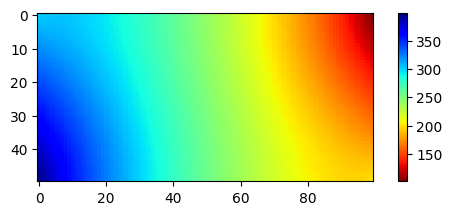

In [20]:
import matplotlib.pyplot as plt

heads = calculation_service.read_head(0, 0)
plt.subplot(2, 1, 1)
plt.imshow(heads, cmap='jet_r')
plt.colorbar()
plt.show()